In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_b25_t1_mask_t1_native_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 934)
(631390, 1)
validation
(74368, 934)
(74368, 1)
test
(85358, 934)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 934)]             0         


 dense (Dense)               (None, 1024)              957440    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1646593 (6.28 MB)


Trainable params: 1646593 (6.28 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:33 - loss: 0.1281 - STD: 2.8265e-04 - MAE: 0.3458

 4/64 [>.............................] - ETA: 1s - loss: 0.0478 - STD: 5.1987e-04 - MAE: 0.1657  

 7/64 [==>...........................] - ETA: 1s - loss: 0.0425 - STD: 3.6395e-04 - MAE: 0.1589

10/64 [===>..........................] - ETA: 1s - loss: 0.0401 - STD: 2.8725e-04 - MAE: 0.1553

13/64 [=====>........................] - ETA: 1s - loss: 0.0363 - STD: 2.6364e-04 - MAE: 0.1437

16/64 [======>.......................] - ETA: 1s - loss: 0.0321 - STD: 2.6531e-04 - MAE: 0.1292

19/64 [=======>......................] - ETA: 1s - loss: 0.0295 - STD: 2.7301e-04 - MAE: 0.1251

22/64 [=========>....................] - ETA: 1s - loss: 0.0279 - STD: 2.7985e-04 - MAE: 0.1241

25/64 [==========>...................] - ETA: 1s - loss: 0.0267 - STD: 2.8444e-04 - MAE: 0.1200

28/64 [============>.................] - ETA: 1s - loss: 0.0251 - STD: 2.8729e-04 - MAE: 0.1139

31/64 [=============>................] - ETA: 1s - loss: 0.0240 - STD: 2.8950e-04 - MAE: 0.1087

34/64 [==============>...............] - ETA: 1s - loss: 0.0231 - STD: 2.9394e-04 - MAE: 0.1044

37/64 [================>.............] - ETA: 1s - loss: 0.0223 - STD: 3.0231e-04 - MAE: 0.1010

40/64 [=================>............] - ETA: 0s - loss: 0.0215 - STD: 3.1468e-04 - MAE: 0.0990

43/64 [===================>..........] - ETA: 0s - loss: 0.0209 - STD: 3.2996e-04 - MAE: 0.0979

46/64 [====================>.........] - ETA: 0s - loss: 0.0204 - STD: 3.4717e-04 - MAE: 0.0968

49/64 [=====================>........] - ETA: 0s - loss: 0.0199 - STD: 3.6532e-04 - MAE: 0.0953

52/64 [=======================>......] - ETA: 0s - loss: 0.0195 - STD: 3.8529e-04 - MAE: 0.0935

55/64 [========================>.....] - ETA: 0s - loss: 0.0191 - STD: 4.0820e-04 - MAE: 0.0919

58/64 [==========================>...] - ETA: 0s - loss: 0.0187 - STD: 4.3575e-04 - MAE: 0.0905

61/64 [===========================>..] - ETA: 0s - loss: 0.0184 - STD: 4.6956e-04 - MAE: 0.0895

64/64 [==============================] - ETA: 0s - loss: 0.0182 - STD: 5.0995e-04 - MAE: 0.0888

64/64 [==============================] - 4s 45ms/step - loss: 0.0182 - STD: 5.0995e-04 - MAE: 0.0888 - val_loss: 0.0165 - val_STD: 0.0011 - val_MAE: 0.0826


Epoch 2/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0125 - STD: 0.0015 - MAE: 0.0736

 4/64 [>.............................] - ETA: 1s - loss: 0.0125 - STD: 0.0016 - MAE: 0.0721

 7/64 [==>...........................] - ETA: 1s - loss: 0.0125 - STD: 0.0017 - MAE: 0.0705

10/64 [===>..........................] - ETA: 1s - loss: 0.0124 - STD: 0.0019 - MAE: 0.0695

13/64 [=====>........................] - ETA: 1s - loss: 0.0124 - STD: 0.0021 - MAE: 0.0691

16/64 [======>.......................] - ETA: 1s - loss: 0.0124 - STD: 0.0023 - MAE: 0.0690

19/64 [=======>......................] - ETA: 1s - loss: 0.0123 - STD: 0.0026 - MAE: 0.0691

22/64 [=========>....................] - ETA: 0s - loss: 0.0123 - STD: 0.0029 - MAE: 0.0690

25/64 [==========>...................] - ETA: 0s - loss: 0.0122 - STD: 0.0033 - MAE: 0.0688

28/64 [============>.................] - ETA: 0s - loss: 0.0121 - STD: 0.0037 - MAE: 0.0684

31/64 [=============>................] - ETA: 0s - loss: 0.0120 - STD: 0.0043 - MAE: 0.0681

34/64 [==============>...............] - ETA: 0s - loss: 0.0119 - STD: 0.0049 - MAE: 0.0677

37/64 [================>.............] - ETA: 0s - loss: 0.0118 - STD: 0.0057 - MAE: 0.0674

40/64 [=================>............] - ETA: 0s - loss: 0.0117 - STD: 0.0067 - MAE: 0.0670

43/64 [===================>..........] - ETA: 0s - loss: 0.0115 - STD: 0.0079 - MAE: 0.0664

46/64 [====================>.........] - ETA: 0s - loss: 0.0113 - STD: 0.0092 - MAE: 0.0658

49/64 [=====================>........] - ETA: 0s - loss: 0.0111 - STD: 0.0108 - MAE: 0.0651

52/64 [=======================>......] - ETA: 0s - loss: 0.0109 - STD: 0.0127 - MAE: 0.0643

55/64 [========================>.....] - ETA: 0s - loss: 0.0107 - STD: 0.0148 - MAE: 0.0634

58/64 [==========================>...] - ETA: 0s - loss: 0.0104 - STD: 0.0171 - MAE: 0.0625

61/64 [===========================>..] - ETA: 0s - loss: 0.0101 - STD: 0.0195 - MAE: 0.0616

64/64 [==============================] - ETA: 0s - loss: 0.0099 - STD: 0.0220 - MAE: 0.0607

64/64 [==============================] - 2s 27ms/step - loss: 0.0099 - STD: 0.0220 - MAE: 0.0607 - val_loss: 0.0062 - val_STD: 0.0570 - val_MAE: 0.0478


Epoch 3/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0042 - STD: 0.0758 - MAE: 0.0399

 4/64 [>.............................] - ETA: 1s - loss: 0.0041 - STD: 0.0786 - MAE: 0.0396

 7/64 [==>...........................] - ETA: 1s - loss: 0.0039 - STD: 0.0811 - MAE: 0.0391

10/64 [===>..........................] - ETA: 1s - loss: 0.0039 - STD: 0.0828 - MAE: 0.0388

13/64 [=====>........................] - ETA: 1s - loss: 0.0038 - STD: 0.0844 - MAE: 0.0384

16/64 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.0858 - MAE: 0.0381

19/64 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0875 - MAE: 0.0379

22/64 [=========>....................] - ETA: 1s - loss: 0.0036 - STD: 0.0884 - MAE: 0.0376

25/64 [==========>...................] - ETA: 0s - loss: 0.0035 - STD: 0.0889 - MAE: 0.0373

28/64 [============>.................] - ETA: 0s - loss: 0.0035 - STD: 0.0897 - MAE: 0.0371

31/64 [=============>................] - ETA: 0s - loss: 0.0034 - STD: 0.0904 - MAE: 0.0369

34/64 [==============>...............] - ETA: 0s - loss: 0.0034 - STD: 0.0909 - MAE: 0.0367

37/64 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0914 - MAE: 0.0366

40/64 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0918 - MAE: 0.0365

43/64 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0923 - MAE: 0.0363

46/64 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0926 - MAE: 0.0362

49/64 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0931 - MAE: 0.0360

52/64 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0934 - MAE: 0.0359

55/64 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0935 - MAE: 0.0357

58/64 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0939 - MAE: 0.0356

61/64 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0941 - MAE: 0.0355

64/64 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0943 - MAE: 0.0353

64/64 [==============================] - 2s 27ms/step - loss: 0.0030 - STD: 0.0943 - MAE: 0.0353 - val_loss: 0.0030 - val_STD: 0.0805 - val_MAE: 0.0361


Epoch 4/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0024 - STD: 0.0990 - MAE: 0.0322

 3/64 [>.............................] - ETA: 1s - loss: 0.0024 - STD: 0.1002 - MAE: 0.0323

 6/64 [=>............................] - ETA: 1s - loss: 0.0023 - STD: 0.1000 - MAE: 0.0319

 9/64 [===>..........................] - ETA: 1s - loss: 0.0023 - STD: 0.0992 - MAE: 0.0318

12/64 [====>.........................] - ETA: 1s - loss: 0.0023 - STD: 0.0992 - MAE: 0.0317

15/64 [======>.......................] - ETA: 1s - loss: 0.0023 - STD: 0.0992 - MAE: 0.0316

18/64 [=======>......................] - ETA: 1s - loss: 0.0022 - STD: 0.0996 - MAE: 0.0315

21/64 [========>.....................] - ETA: 1s - loss: 0.0022 - STD: 0.0995 - MAE: 0.0314

24/64 [==========>...................] - ETA: 0s - loss: 0.0022 - STD: 0.0993 - MAE: 0.0313

27/64 [===========>..................] - ETA: 0s - loss: 0.0022 - STD: 0.0995 - MAE: 0.0312

30/64 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.0996 - MAE: 0.0311

33/64 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0310

36/64 [===============>..............] - ETA: 0s - loss: 0.0021 - STD: 0.0999 - MAE: 0.0309

39/64 [=================>............] - ETA: 0s - loss: 0.0021 - STD: 0.1000 - MAE: 0.0308

42/64 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.1001 - MAE: 0.0307

45/64 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.1003 - MAE: 0.0306

48/64 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.1004 - MAE: 0.0305

51/64 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1006 - MAE: 0.0304

54/64 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1008 - MAE: 0.0304

57/64 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1009 - MAE: 0.0303

60/64 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1011 - MAE: 0.0303

63/64 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1012 - MAE: 0.0302

64/64 [==============================] - 2s 27ms/step - loss: 0.0020 - STD: 0.1012 - MAE: 0.0302 - val_loss: 0.0020 - val_STD: 0.0906 - val_MAE: 0.0308


Epoch 5/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0018 - STD: 0.1020 - MAE: 0.0291

 4/64 [>.............................] - ETA: 1s - loss: 0.0018 - STD: 0.1030 - MAE: 0.0290

 7/64 [==>...........................] - ETA: 1s - loss: 0.0018 - STD: 0.1036 - MAE: 0.0289

10/64 [===>..........................] - ETA: 1s - loss: 0.0018 - STD: 0.1032 - MAE: 0.0289

13/64 [=====>........................] - ETA: 1s - loss: 0.0018 - STD: 0.1032 - MAE: 0.0289

16/64 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.1033 - MAE: 0.0288

19/64 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.1036 - MAE: 0.0288

22/64 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0288

25/64 [==========>...................] - ETA: 0s - loss: 0.0018 - STD: 0.1034 - MAE: 0.0287

28/64 [============>.................] - ETA: 0s - loss: 0.0018 - STD: 0.1036 - MAE: 0.0287

31/64 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0287

34/64 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0287

37/64 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0286

40/64 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0286

43/64 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0286

46/64 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0286

49/64 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0285

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0285

55/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0285

58/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0285

61/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0284

64/64 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0284

64/64 [==============================] - 2s 27ms/step - loss: 0.0017 - STD: 0.1038 - MAE: 0.0284 - val_loss: 0.0018 - val_STD: 0.0912 - val_MAE: 0.0291


Epoch 6/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0017 - STD: 0.0990 - MAE: 0.0283

 4/64 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0280

 7/64 [==>...........................] - ETA: 1s - loss: 0.0017 - STD: 0.1026 - MAE: 0.0279

10/64 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1034 - MAE: 0.0279

13/64 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0280

16/64 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0280

19/64 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0280

22/64 [=========>....................] - ETA: 0s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0281

25/64 [==========>...................] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0281

28/64 [============>.................] - ETA: 0s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0280

31/64 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0280

34/64 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0279

37/64 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0279

40/64 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0279

43/64 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0279

46/64 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0279

49/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0278

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0278

55/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0278

58/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0278

61/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0278

64/64 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0278

64/64 [==============================] - 2s 26ms/step - loss: 0.0017 - STD: 0.1043 - MAE: 0.0278 - val_loss: 0.0022 - val_STD: 0.0975 - val_MAE: 0.0316


Epoch 7/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0017 - STD: 0.1086 - MAE: 0.0281

 3/64 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0279

 6/64 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0278

 9/64 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277

12/64 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

15/64 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0275

18/64 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0275

21/64 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0274

24/64 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0274

27/64 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0274

30/64 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0274

33/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0274

36/64 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0273

39/64 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0273

42/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0273

45/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0273

48/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0273

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0273

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0272

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0272

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0272

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0272

64/64 [==============================] - 2s 27ms/step - loss: 0.0016 - STD: 0.1048 - MAE: 0.0272 - val_loss: 0.0019 - val_STD: 0.0971 - val_MAE: 0.0299


Epoch 8/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1094 - MAE: 0.0272

 4/64 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1074 - MAE: 0.0270

 7/64 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1068 - MAE: 0.0270

10/64 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1067 - MAE: 0.0270

13/64 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0270

16/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0270

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0270

22/64 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0270

25/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0270

28/64 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0271

31/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0270

34/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

40/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

43/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0269

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0269

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0269

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0269

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

64/64 [==============================] - 2s 26ms/step - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268 - val_loss: 0.0018 - val_STD: 0.0962 - val_MAE: 0.0290


Epoch 9/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1069 - MAE: 0.0266

 4/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1067 - MAE: 0.0265

 7/64 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0265

10/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

16/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

22/64 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0267

25/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0267

28/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0267

31/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0267

34/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0266

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0266

40/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0267

43/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0267

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

64/64 [==============================] - 2s 26ms/step - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266 - val_loss: 0.0024 - val_STD: 0.1005 - val_MAE: 0.0333


Epoch 10/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0017 - STD: 0.1113 - MAE: 0.0283

 3/64 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.1086 - MAE: 0.0284

 6/64 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1076 - MAE: 0.0279

 9/64 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0275

12/64 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

15/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0271

18/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

21/64 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

24/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

27/64 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

30/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

33/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

36/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

39/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0270

42/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

45/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0269

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0269

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0270

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0270

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

64/64 [==============================] - 2s 27ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268 - val_loss: 0.0017 - val_STD: 0.0954 - val_MAE: 0.0284


Epoch 11/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1038 - MAE: 0.0265

 4/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0267

 7/64 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0266

10/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

16/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

22/64 [=========>....................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

25/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0270

28/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0272

31/64 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0274

34/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0276

37/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0276

40/64 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0275

43/64 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0274

46/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0274

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0272

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0271

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0271

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0270

64/64 [==============================] - 2s 27ms/step - loss: 0.0015 - STD: 0.1054 - MAE: 0.0270 - val_loss: 0.0017 - val_STD: 0.0968 - val_MAE: 0.0285


Epoch 12/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

 4/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0261

 7/64 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0263

10/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

16/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0262

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

22/64 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

25/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

28/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

30/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

33/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

36/64 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

39/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0262

42/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

45/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0262

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

64/64 [==============================] - 2s 27ms/step - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262 - val_loss: 0.0019 - val_STD: 0.0987 - val_MAE: 0.0302


Epoch 13/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1098 - MAE: 0.0263

 4/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0262

 7/64 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0264

10/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0264

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0265

16/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

22/64 [=========>....................] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

25/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

28/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

31/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

34/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

40/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0263

43/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0263

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0263

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0263

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0263

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0263

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0263

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0263

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

64/64 [==============================] - 2s 27ms/step - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263 - val_loss: 0.0015 - val_STD: 0.0924 - val_MAE: 0.0279


Epoch 14/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1030 - MAE: 0.0291

 4/64 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276

 7/64 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0274

10/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0271

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0269

16/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0268

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0268

22/64 [=========>....................] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0268

25/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0269

28/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0270

31/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0271

34/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0272

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0273

40/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0273

43/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0272

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0271

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0271

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0271

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0270

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0270

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0269

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0269

64/64 [==============================] - 2s 27ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0269 - val_loss: 0.0017 - val_STD: 0.0971 - val_MAE: 0.0285


Epoch 15/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0261

 4/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0258

 7/64 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0259

10/64 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0258

13/64 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

16/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

19/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

22/64 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

25/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

28/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

31/64 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

34/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

37/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

40/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

43/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0263

64/64 [==============================] - 2s 27ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0263 - val_loss: 0.0015 - val_STD: 0.0948 - val_MAE: 0.0274


Epoch 16/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1035 - MAE: 0.0263

 4/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0262

 7/64 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0262

10/64 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0262

13/64 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0262

16/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0262

19/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

22/64 [=========>....................] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

25/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

28/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

31/64 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0261

34/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0261

37/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0261

40/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

43/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

64/64 [==============================] - 2s 27ms/step - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260 - val_loss: 0.0015 - val_STD: 0.0955 - val_MAE: 0.0273


Epoch 17/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263

 4/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1069 - MAE: 0.0262

 7/64 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0261

10/64 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

13/64 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

16/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

19/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

22/64 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

25/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

28/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

31/64 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

34/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

37/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

40/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

43/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

64/64 [==============================] - 2s 27ms/step - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259 - val_loss: 0.0017 - val_STD: 0.0976 - val_MAE: 0.0282


Epoch 18/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

 4/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1044 - MAE: 0.0255

 7/64 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1046 - MAE: 0.0256

10/64 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0258

13/64 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

16/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0259

19/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0259

22/64 [=========>....................] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

25/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

28/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

31/64 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

34/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

37/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

40/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

43/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

64/64 [==============================] - 2s 27ms/step - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257 - val_loss: 0.0015 - val_STD: 0.0961 - val_MAE: 0.0273


Epoch 19/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1044 - MAE: 0.0255

 4/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0256

 7/64 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

10/64 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

13/64 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

16/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

19/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0258

22/64 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

25/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

28/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

31/64 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0258

34/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

37/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

40/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

43/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

64/64 [==============================] - 2s 26ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258 - val_loss: 0.0016 - val_STD: 0.0975 - val_MAE: 0.0278


Epoch 20/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0254

 4/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1043 - MAE: 0.0271

 7/64 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0269

10/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0271

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0268

16/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0268

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0266

22/64 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0265

25/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0264

28/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0263

31/64 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0263

34/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0262

37/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0262

40/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

43/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0262

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

64/64 [==============================] - 2s 26ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261 - val_loss: 0.0017 - val_STD: 0.0986 - val_MAE: 0.0285


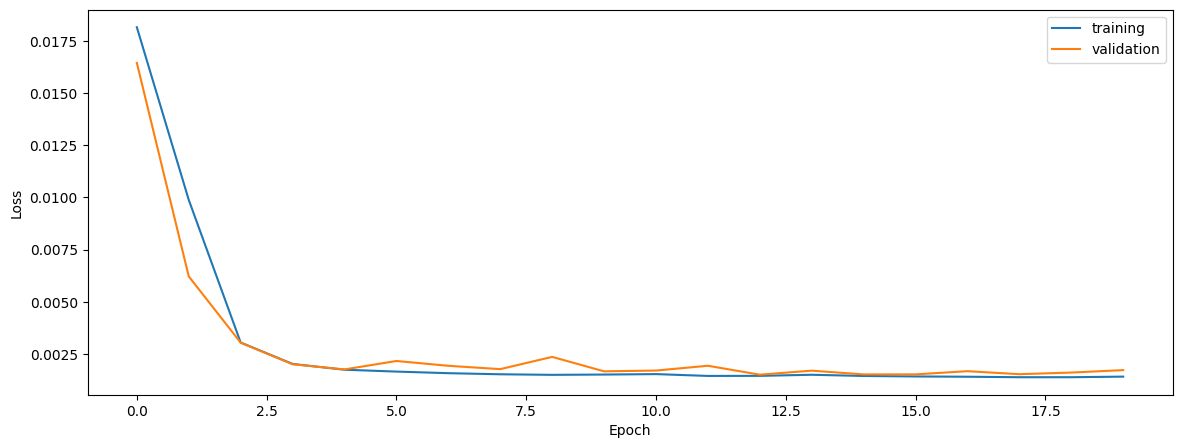

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.9418317544817018
0.954705407291204
0.9495943348770768


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.9430348213540019
0.9521680726427229
0.9504960956640717


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.949893275372899
0.9542134889179236
0.9621774041787404


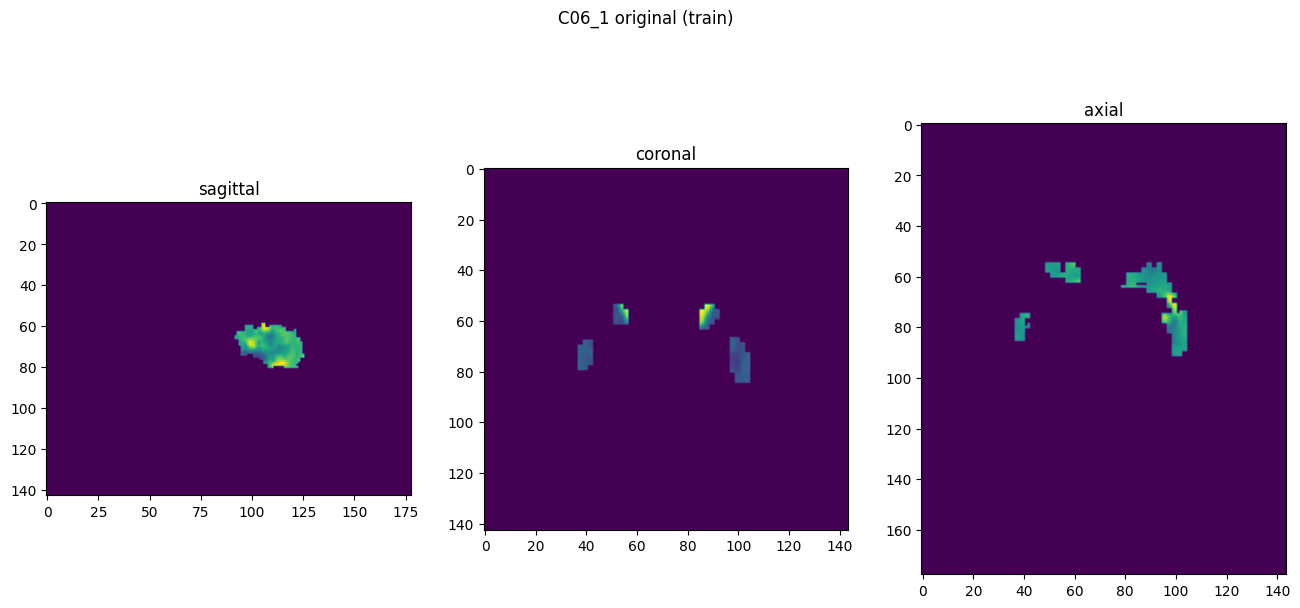

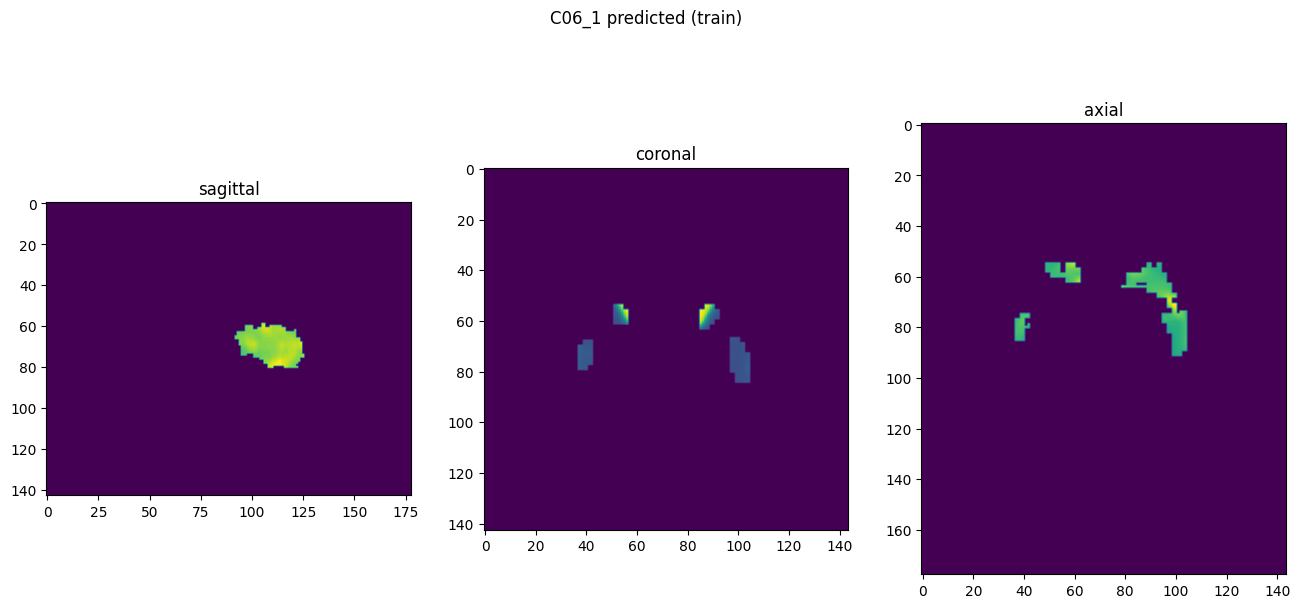

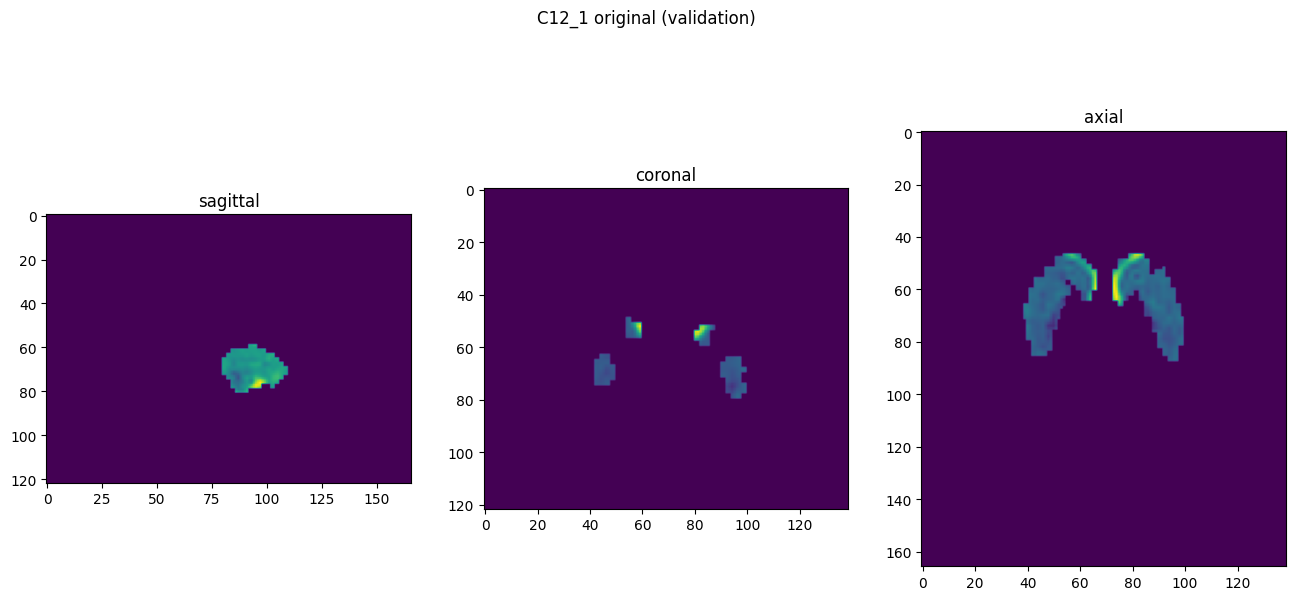

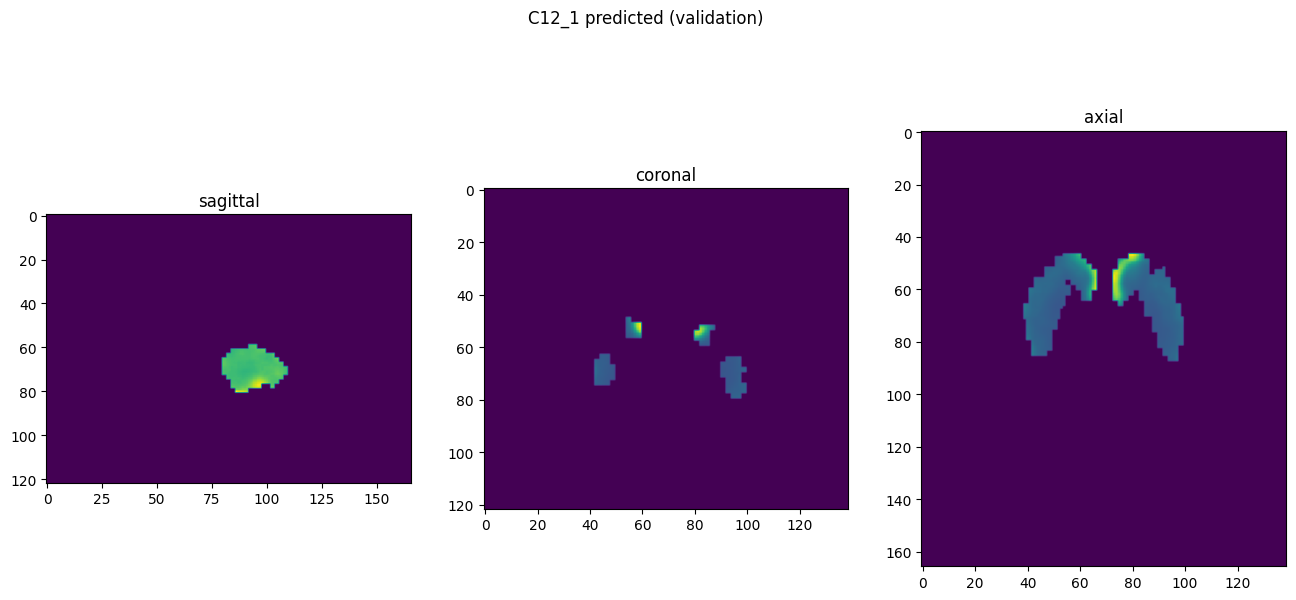

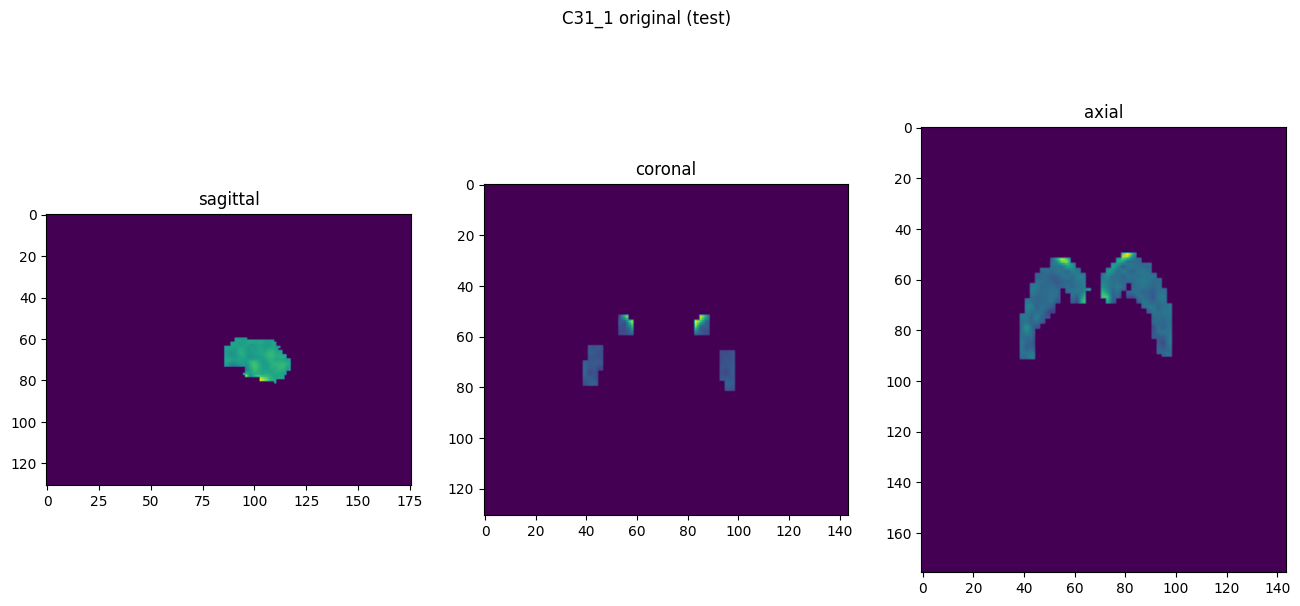

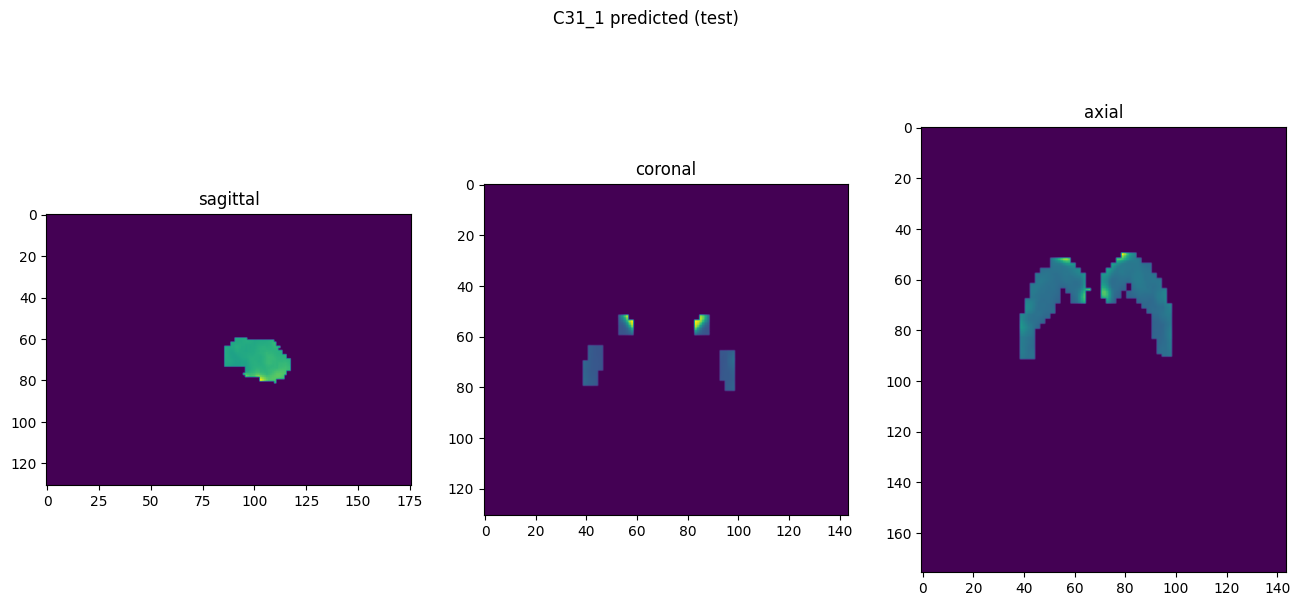

In [10]:
showResults(model, gen, threshold=None, background=False)